# BERT for dummies — Step by Step Tutorial
https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03


* [캐글 데이터셋](https://www.kaggle.com/siddhadev/ms-cntk-atis) 에서 Notebook을 생성하여 진행하였음.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ms-cntk-atis/atis.train.query.csv
/kaggle/input/ms-cntk-atis/atis.dict.intent.csv
/kaggle/input/ms-cntk-atis/atis.train.slots.csv
/kaggle/input/ms-cntk-atis/atis.train.pkl
/kaggle/input/ms-cntk-atis/atis.test.slots.csv
/kaggle/input/ms-cntk-atis/atis.test.pkl
/kaggle/input/ms-cntk-atis/atis.test.intent.csv
/kaggle/input/ms-cntk-atis/atis.dict.vocab.csv
/kaggle/input/ms-cntk-atis/atis.dict.slots.csv
/kaggle/input/ms-cntk-atis/atis.test.query.csv
/kaggle/input/ms-cntk-atis/atis.train.intent.csv
/kaggle/input/ms-cntk-atis/atis/atis.train.query.csv
/kaggle/input/ms-cntk-atis/atis/atis.dict.intent.csv
/kaggle/input/ms-cntk-atis/atis/atis.train.slots.csv
/kaggle/input/ms-cntk-atis/atis/atis.train.pkl
/kaggle/input/ms-cntk-atis/atis/atis.test.slots.csv
/kaggle/input/ms-cntk-atis/atis/atis.test.pkl
/kaggle/input/ms-cntk-atis/atis/atis.test.intent.csv
/kaggle/input/ms-cntk-atis/atis/atis.dict.vocab.csv
/kaggle/input/ms-cntk-atis/atis/atis.dict.slots.csv
/kaggle/input/ms-cntk-atis/

## Exploring the ATIS Dataset

In [3]:
import pickle
DATA_DIR="../input/ms-cntk-atis"

# load Pickle file 
def load_ds(fname=os.path.join(DATA_DIR,'/atis.train.pkl'), verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
      print('Done  loading: ', fname)
      print('      samples: {:4d}'.format(len(ds['query'])))
      print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
      print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
      print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
          print('Query text:', q)
          print('Query vector: ', query[i])
          print('Intent label: ', i2in[intent[i][0]])
          print('Slot text: ', slot)
          print('Slot vector: ', slot_vector)
          print('*'*74)
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, \
           query_data, intent_data, intent_data_label, slot_data

# load ATIS training dataset
t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
input_tensor_train, target_tensor_train, \
query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')

# load ATIS testing dataset
t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
input_tensor_test, target_tensor_test, \
query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
  


Done  loading:  ../input/ms-cntk-atis/atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS i would like a nonstop flight from new york to las vegas on march second EOS
Query vector:  [178 479 932 545 180 629 428 444 619 937 851 527 897 654 576 753 179]
Intent label:  flight
Slot text:  O O O O O B-flight_stop O O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-arrive_date.month_name B-arrive_date.day_number O
Slot vector:  [128, 128, 128, 128, 128, 44, 128, 128, 48, 110, 128, 78, 125, 128, 8, 7, 128]
**************************************************************************
Query text: BOS show me the airlines that fly between toronto and denver EOS
Query vector:  [178 770 581 827 200 826 431 259 856 215 351 179]
Intent label:  airline
Slot text:  O O O O O O O O B-fromloc.city_name O B-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 128, 48, 128, 78, 128]
*******************

# Intent classification with LSTM


In [5]:
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'query': query_data_train, 'intent': intent_data_train, 'slot filling': slot_data_train})

df_small = pd.DataFrame(columns=['query','intent','slot filling'])
j = 0
for i in df.intent.unique():
  df_small.loc[j] = df[df.intent==i].iloc[0]
  j = j+1
  
df_small

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,query,intent,slot filling
0,i want to fly from boston at 838 am and arrive in denver at 1110 in the morning,flight,O O O O O B-fromloc.city_name O B-depart_time.time I-depart_time.time O O O B-toloc.city_name O B-arrive_time.time O O B-arrive_time.period_of_day
1,what is the arrival time in san francisco for the 755 am flight leaving washington,flight_time,O O O B-flight_time I-flight_time O B-fromloc.city_name I-fromloc.city_name O O B-depart_time.time I-depart_time.time O O B-fromloc.city_name
2,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-toloc.city_name
3,what kind of aircraft is used on a flight from cleveland to dallas,aircraft,O O O O O O O O O O B-fromloc.city_name O B-toloc.city_name
4,what kind of ground transportation is available in denver,ground_service,O O O O O O O O B-city_name
5,what 's the airport at orlando,airport,O O O O O B-city_name
6,which airline serves denver pittsburgh and atlanta,airline,O O O B-fromloc.city_name B-fromloc.city_name O B-fromloc.city_name
7,how far is it from orlando airport to orlando,distance,O O O O O B-fromloc.airport_name I-fromloc.airport_name O B-toloc.city_name
8,what is fare code h,abbreviation,O O O O B-fare_basis_code
9,how much does the limousine service cost within pittsburgh,ground_fare,O O O O B-transport_type O O O B-city_name


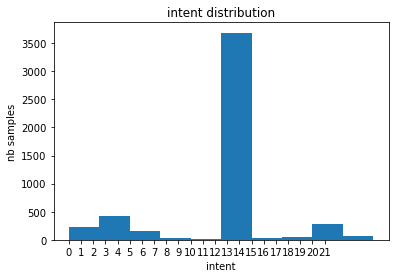

In [4]:
# intent distribution --> highly unbalanced

import matplotlib.pyplot as plt
labels = intent_data_label_train
plt.hist(labels)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution')
plt.xticks(np.arange(len(np.unique(labels))));

## Creating Tensors


In [5]:
def max_length(tensor):
    return max(len(t) for t in tensor)

# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], \
           len_input, len_target 
           
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)
input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)


In [6]:
def get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test):
    vocab_in_size = len({**t2i_train, **t2i_test})
    vocab_out_size = len({**s2i_train, **s2i_test})
    return vocab_in_size, vocab_out_size
  
vocab_in_size, vocab_out_size = get_vocab_size(t2i_train, t2i_test, s2i_train, s2i_test)
vocab_in_size, vocab_out_size

(943, 129)

### One-hot encoding (intent_data_label_train)

In [7]:
indices = intent_data_label_train
depth = 26
encoded = tf.one_hot(indices, depth)

In [8]:
intent_data_label_train[:5], encoded[:5]

(array([14, 14, 19,  3,  3]),
 <tf.Tensor: shape=(5, 26), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>)

In [9]:
intent_data_label_train[6], encoded[6]

(1,
 <tf.Tensor: shape=(26,), dtype=float32, numpy=
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

## Multi-class classifier


Before looking at Transformer, we implement a simple LSTM recurrent network for solving the classification task. After the usual preprocessing, tokenization and vectorization, **the 4978 samples are fed into a Keras Embedding layer**, which projects each word as a Word2vec **embedding of dimension 256.** The results are passed through a LSTM layer with **1024 cells.** This produces 1024 outputs which are given to **a Dense layer with 26 nodes** and softmax activation. The probabilities created at the end of this pipeline are compared to the original labels using categorical crossentropy.

In [10]:
'''
위의 설명에 따라 하이퍼파라미터 설정
'''
embedding_dim = 256
units = 1024
nb_labels = 26
BATCH_SIZE = 64 # NO Batch 하면 이 article 처럼 4978/4978 나올 것임.

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm.add(tf.keras.layers.LSTM(units))
model_lstm.add(tf.keras.layers.Dense(26, activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

history_lstm = model_lstm.fit(input_data_train, encoded , \
                              epochs=10,batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 48, 256)           241408    
_________________________________________________________________
lstm (LSTM)                  (None, 1024)              5246976   
_________________________________________________________________
dense (Dense)                (None, 26)                26650     
Total params: 5,515,034
Trainable params: 5,515,034
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
78/78 [==============================] - 2s 30ms/step - loss: 1.2887 - accuracy: 0.7284
Epoch 2/10
78/78 [==============================] - 2s 30ms/step - loss: 1.1469 - accuracy: 0.7364
Epoch 3/10
78/78 [==============================] - 2s 30ms/step - loss: 1.1467 - accuracy: 0.7364
Epoch 4/10
78/78 [==============================] - 2s 31ms/step - loss: 1.1430

In [11]:
def preprocess_query(w):
    w = w.rstrip().strip().lower()
    w = "BOS " + w + " EOS"
    return w

In [12]:
def query_to_vector(query, len_input=len_input_train, t2i=t2i_train):
    pre = preprocess_query(query)
    vec = np.zeros(len_input)
    query_list = [t2i[s] for s in pre.split(' ')]
    for i,w in enumerate(query_list):
        vec[i] = w
    return vec

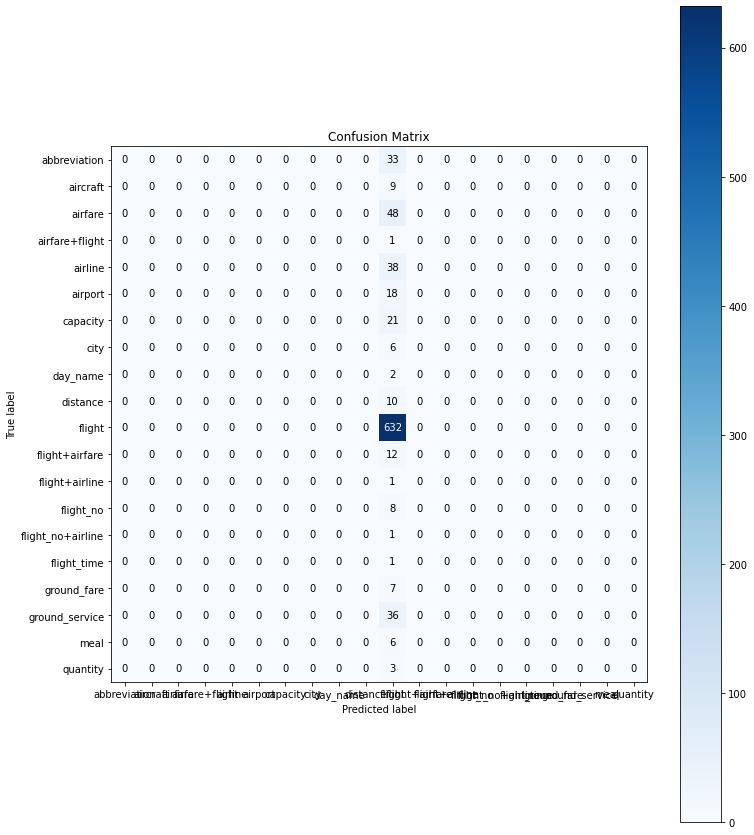

In [13]:
import scikitplot as skplt

def predict_intent(input_query, model=model_lstm, i2in=i2in_test, verbose=False):
  sv = query_to_vector(input_query)
  sv = sv.reshape(1,len(sv))
  intent_idx = np.argmax(model.predict(sv), axis=1)[0]
  intent_label = i2in[intent_idx]
  if verbose:
    print(intent_label)
  return intent_label, intent_idx

def evaluate_intent(queries, true_intents, model):
  predicted_intents = []
  for q in queries:
    intent_label, intent_idx = predict_intent(q, model)
    predicted_intents.append(intent_label)
  skplt.metrics.plot_confusion_matrix(true_intents, predicted_intents, figsize=(12,15))
  
true_intents = [i2in_test[i] for i in intent_data_label_test]
evaluate_intent(query_data_test, true_intents, model_lstm)

When we use the trained model to predict the intents on the unseen test dataset, **the confusion matrix clearly shows how the model overfits to the majority “flight” class.**

## Binary classifier

Since we were not quite successful at augmenting the dataset, now, **we will rather reduce the scope of the problem.** We define a binary classification task where **the “flight” queries are evaluated against the remaining classes**, by collapsing them into a single class called **“other”.** The distribution of labels in this new dataset is given below.

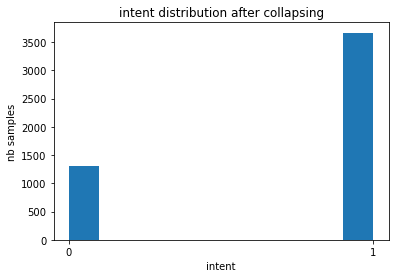

In [14]:
labels[labels==14] = -1
labels[labels!=-1] = 0
labels[labels==-1] = 1

plt.hist(labels)
plt.xlabel('intent')
plt.ylabel('nb samples')
plt.title('intent distribution after collapsing')
plt.xticks(np.arange(len(np.unique(labels))));

We can now use a similar network architecture as previously. The only change is **to reduce the number of nodes in the Dense layer to 1**, activation function to sigmoid and the **loss function to binary crossentropy.** Surprisingly, the LSTM model is still not able to learn to predict the intent, given the user query, as we see below.

In [15]:
model_lstm2 = tf.keras.Sequential()
model_lstm2.add(tf.keras.layers.Embedding(vocab_in_size, embedding_dim, input_length=len_input_train))
model_lstm2.add(tf.keras.layers.LSTM(units))
model_lstm2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model_lstm2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_lstm2 = model_lstm2.fit(input_data_train, labels, epochs=10, batch_size=1)


Epoch 1/10
4978/4978 [==============================] - 59s 12ms/step - loss: 0.6018 - accuracy: 0.7324
Epoch 2/10
4978/4978 [==============================] - 59s 12ms/step - loss: 0.5838 - accuracy: 0.7362
Epoch 3/10
4978/4978 [==============================] - 59s 12ms/step - loss: 0.5858 - accuracy: 0.7364
Epoch 4/10
4978/4978 [==============================] - 59s 12ms/step - loss: 0.5841 - accuracy: 0.7364
Epoch 5/10
4978/4978 [==============================] - 58s 12ms/step - loss: 0.5851 - accuracy: 0.7364
Epoch 6/10
4978/4978 [==============================] - 58s 12ms/step - loss: 0.5850 - accuracy: 0.7364
Epoch 7/10
4978/4978 [==============================] - 59s 12ms/step - loss: 0.5846 - accuracy: 0.7364
Epoch 8/10
4978/4978 [==============================] - 59s 12ms/step - loss: 0.5826 - accuracy: 0.7364
Epoch 9/10
4978/4978 [==============================] - 59s 12ms/step - loss: 0.5838 - accuracy: 0.7364
Epoch 10/10
4978/4978 [==============================] - 58s 12m

After 10 epochs, we evaluate the model on **an unseen test dataset.** This time, we have all samples being predicted as “other”, although “flight” had more than twice as many samples as “other” in the training set.

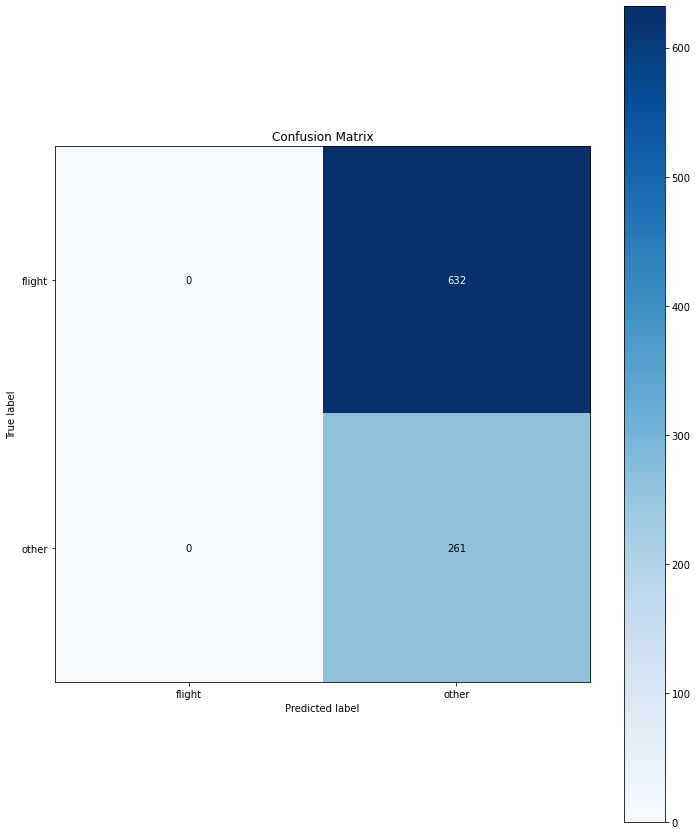

In [16]:
true_intents = ['flight' if i==14 else 'other' for i in intent_data_label_test]
predicted_intents = []
for q in query_data_test:
    intent_label, intent_idx = predict_intent(q, model_lstm2)
    predicted_intents.append('flight' if intent_idx==1 else 'other')
    
skplt.metrics.plot_confusion_matrix(true_intents, predicted_intents, figsize=(12,15))

# Intent Classification with BERT

In [7]:
# install
!pip install pytorch-pretrained-bert pytorch-nlp

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

     |████████████████████████████████| 123 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 2.7 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


'Tesla P100-PCIE-16GB'

BERT expects input data in a specific format, **with special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]).** 

Furthermore, **we need to tokenize our text into tokens that correspond to BERT’s vocabulary.**

In [8]:
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

[CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]


100%|██████████| 231508/231508 [00:00<00:00, 2581326.29B/s]


Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


For each tokenized sentence, BERT requires input ids, a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary.

In [9]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


BERT’s clever language modeling task masks 15% of words in the input and asks the model to predict the missing word. 

To make BERT better at handling relationships between multiple sentences, the pre-training process also included an additional task: 

given two sentences (A and B), is B likely to be the sentence that follows A? 


Therefore we need to tell BERT what task we are solving **by using the concept of attention mask and segment mask.** 
**In our case, all words in a query will be predicted and we do not have multiple sentences per query.** We define the mask below.

In [10]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

### Fine-tuning of BERT using our data

In [11]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


we use the **BertForSequenceClassification**, which is the normal BERT model with an added single linear layer on top for classification.

The encoder summary is shown only once. The same summary would normally be repeated 12 times. We display only 1 of them for simplicity sake. 

We can see the **BertEmbedding layer at the beginning**, followed by a **Transformer architecture for each encoder layer: BertAttention, BertIntermediate, BertOutput. At the end, we have the Classifier layer.**

In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=26)
model.to(device)


100%|██████████| 407873900/407873900 [00:10<00:00, 38504667.52B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

### Model Summary

```
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=nb_labels)
model.cuda()

# BERT model summary
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1)
          )
        )
        '
        '
        '
      )
    )
    (pooler): BertPooler(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (activation): Tanh()
    )
  )
  (dropout): Dropout(p=0.1)
  (classifier): Linear(in_features=768, out_features=2, bias=True)
)
```

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


Train loss: 0.546633022118892


Epoch:  25%|██▌       | 1/4 [01:13<03:40, 73.65s/it]

Validation Accuracy: 0.9750434027777778
Train loss: 0.1385160815502916


Epoch:  50%|█████     | 2/4 [02:26<02:26, 73.50s/it]

Validation Accuracy: 0.98828125
Train loss: 0.07451000958681106


Epoch:  75%|███████▌  | 3/4 [03:39<01:13, 73.34s/it]

Validation Accuracy: 0.982421875
Train loss: 0.05244713904602187


Epoch: 100%|██████████| 4/4 [04:52<00:00, 73.25s/it]

Validation Accuracy: 0.9921875


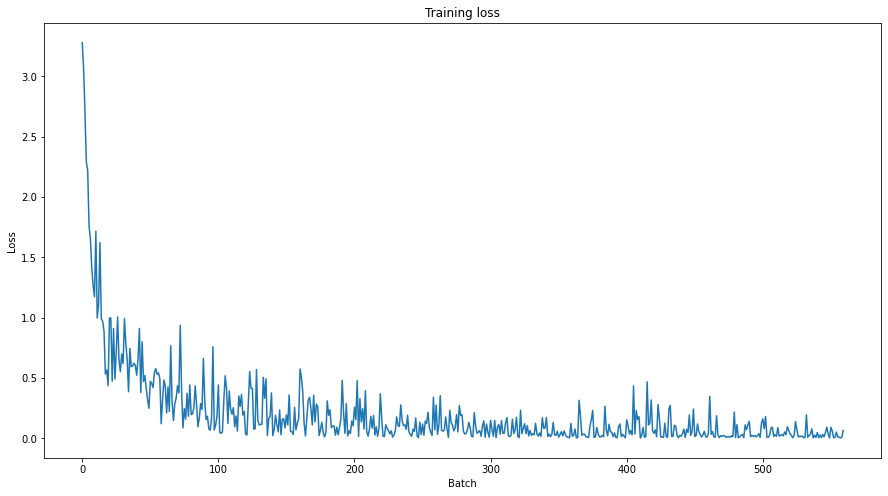

In [13]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
  model.train()  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1
  print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
  model.eval()
  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1
  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

Now, it is the moment of truth. Is BERT overfitting? Or is it doing better than our previous LSTM network? 

**We now load the test dataset and prepare inputs just as we did with the training set.** We then create tensors and run the model on the dataset in evaluation mode.

In [14]:
# load test data
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_test]
labels = intent_data_label_test

# tokenize test data
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# create test tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
batch_size = 32  
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Prediction on test set
# Put model in evaluation mode
model.eval()
# Tracking variables 
predictions , true_labels = [], []
# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
  
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []
for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)
  
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))


Classification accuracy using BERT Fine Tuning: 95.21%


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


With BERT we are able to get a good score (95.21%) on the intent classification task. 